In [1]:
import pandas as pd
import numpy as np
from functions import *
from models import *
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# set default plotting parameters
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})


%load_ext autoreload
%autoreload 2

**Table of contents**<a id='toc0_'></a>    
- [Create simulated values](#toc1_)    
- [Estimate models with simulated data](#toc2_)    
  - [OLS](#toc2_1_)    
    - [Linear model](#toc2_1_1_)    
    - [Non-normal model](#toc2_1_2_)    
    - [Non-linear model](#toc2_1_3_)    
  - [LASSO (OLS)](#toc2_2_)    
    - [Linear model](#toc2_2_1_)    
    - [Non-normal model](#toc2_2_2_)    
    - [Non-linear model](#toc2_2_3_)    
  - [MLP](#toc2_3_)    
    - [General setup](#toc2_3_1_)    
    - [Linear model](#toc2_3_2_)    
      - [Setup](#toc2_3_2_1_)    
      - [Training](#toc2_3_2_2_)    
      - [Prediction](#toc2_3_2_3_)    
    - [Non-normal model](#toc2_3_3_)    
      - [Setup](#toc2_3_3_1_)    
    - [Non-linear model](#toc2_3_4_)    
      - [Setup](#toc2_3_4_1_)    
      - [Training](#toc2_3_4_2_)    
      - [Prediction](#toc2_3_4_3_)    
- [Results](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Create simulated values](#toc0_)

In [2]:
# load raw data
data = pd.read_csv('data/data.csv')

# financials[(financials['ticker'] == 'INVb.CO^F05')]
baspread = data[(data['ticker'] == 'NOVOb.CO')]['baspread'].values *100
mom12m = data[(data['ticker'] == 'NOVOb.CO')]['mom12m'].values * 100
mom6m = data[(data['ticker'] == 'NOVOb.CO')]['mom6m'].values * 100
mom3m = data[(data['ticker'] == 'NOVOb.CO')]['mom3m'].values * 100
mom1m = data[(data['ticker'] == 'NOVOb.CO')]['mom1m'].values * 100
baspread_large = data[(data['ticker'] == 'MAERSKb.CO') | (data['ticker']=='NOVOb.CO') | (data['ticker']=='CARLb.CO')]['baspread']*100
# remove outliers
baspread_large = baspread_large[(baspread_large < 1)]

In [3]:
np.random.seed(42)
theta = 3
lambda_ = 0.05
const = 0.0
datapoints = 100
datapoints_train = int(datapoints * 0.7)

# create simulations
x = baspread[-datapoints:]
# x_outofsample = baspread[100:200]

# linear
y1 = theta * x + const + np.random.normal(0, 0.01, len(x))
y1_train = y1[:datapoints_train]
y1_test = y1[datapoints_train:]

# non-normal error
y2 = theta * x + const + np.random.standard_t(1, len(x)) * 0.01
y2_train = y2[:datapoints_train]
y2_test = y2[datapoints_train:]


# non-linear
y3 = theta**3 * x**2 + const + np.abs(x-lambda_) + np.random.normal(0, 0.01, len(x))
y3_train = y3[:datapoints_train]
y3_test = y3[datapoints_train:]

# make x 2 dimensional
x = x.reshape(-1, 1)

# create noise features
n_noise = 19
noise = x/2 + np.random.normal(0, np.std(x), size=(len(x), n_noise))


# noise = np.concatenate((
#                         noise_corr,
#                         ), axis=1)


# add constant term
x = np.concatenate((np.ones((len(x), 1)), x), axis=1)
x_noise = np.concatenate((x, noise), axis=1)


# split data
x_train_noise = x_noise[:datapoints_train]
x_test_noise = x_noise[datapoints_train:]
x_train = x[:datapoints_train]
x_test = x[datapoints_train:]



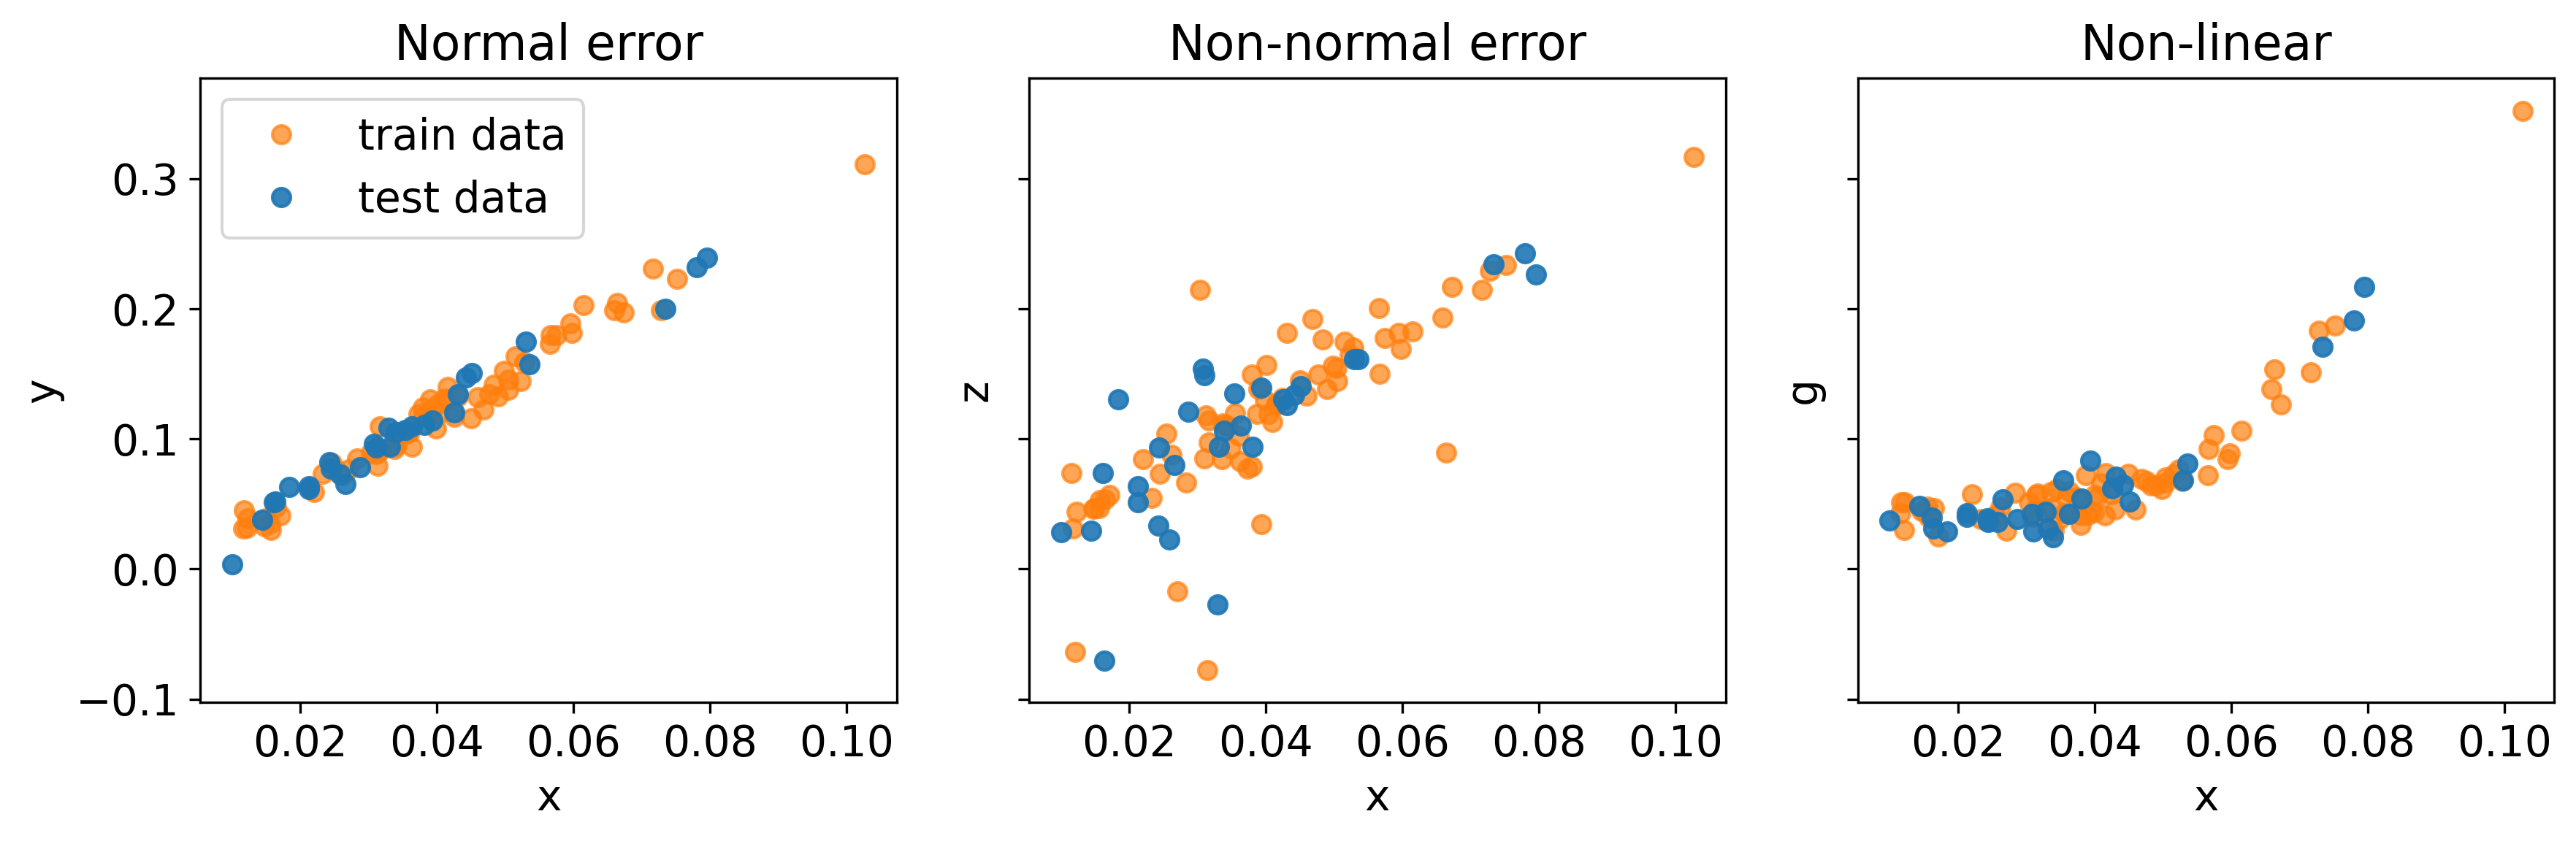

In [4]:
all_y = np.concatenate([y1_train, y1_test, y2_train, y2_test, y3_train, y3_test])
y_min, y_max = all_y.min()-0.025, all_y.max()+0.025
fig = plt.figure(figsize=(12, 4))



# plot the simulations
plt.subplot(1, 3, 1)
plt.plot(x_train[:,1], y1_train, 'o', label='train data', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y1_test, 'o', label='test data', color='C0', alpha=0.9)
plt.legend(loc='upper left', fontsize=14)
plt.yticks(np.arange(-0.1, 0.5, 0.1), fontsize=14)
plt.xticks(fontsize=14)
plt.ylim(y_min, y_max)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title('Normal error', fontsize=16)

plt.subplot(1, 3, 2)
plt.plot(x_train[:,1], y2_train, 'o', label='train', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y2_test, 'o', label='test', color='C0', alpha=0.9)
plt.yticks(np.arange(-0.1, 0.5, 0.1), fontsize=14)
plt.xticks(fontsize=14)
plt.ylim(y_min, y_max)
plt.gca().set_yticklabels([]) 
plt.xlabel('x', fontsize=14)
plt.ylabel('z', fontsize=14)
plt.title('Non-normal error', fontsize=16)

plt.subplot(1, 3, 3)
plt.plot(x_train[:,1], y3_train, 'o', label='train', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y3_test, 'o', label='test', color='C0', alpha=0.9)
plt.yticks(np.arange(-0.1, 0.5, 0.1), fontsize=14)
plt.xticks(fontsize=14)
plt.ylim(y_min, y_max)
plt.gca().set_yticklabels([]) 
plt.xlabel('x', fontsize=14)
plt.ylabel('g', fontsize=14)
plt.title('Non-linear', fontsize=16)

plt.tight_layout()
plt.savefig('output/simulation-data.png', dpi=300)
plt.show()
plt.close()

# <a id='toc2_'></a>[Estimate models with simulated data](#toc0_)

## <a id='toc2_1_'></a>[OLS](#toc0_)

### <a id='toc2_1_1_'></a>[Linear model](#toc0_)

In [5]:
# linear model
# estimate the parameters
ols_est1 = estimate(y1_train,x_train)

# for i in ols_est1:
#     print(i, ols_est1[i])

print(ols_est1['b_hat'])
# print(ols_est1['se'])

ols_pred1 = ols_est1['b_hat'] @ x_test.T

[-0.00521934  3.09651467]


### <a id='toc2_1_2_'></a>[Non-normal model](#toc0_)

In [6]:
# linear model
# estimate the parameters
ols_est2 = estimate(y2_train,x_train)

print(ols_est2['b_hat'])
# print(ols_est2['se'])

ols_pred2 = ols_est2['b_hat'] @ x_test.T

[-0.00516583  3.10081345]


### <a id='toc2_1_3_'></a>[Non-linear model](#toc0_)

In [7]:
# non-linear model
# estimate the parameters
ols_est3 = estimate(y3_train,x_train)

print(ols_est3['b_hat'])
# print(ols_est3['se'])

ols_pred3 = ols_est3['b_hat'] @ x_test.T

[-0.02037604  2.2135834 ]


### Noise models

In [8]:
# estimate the parameters and predict
ols_est1n = estimate(y1_train,x_train_noise)
print(ols_est1n['b_hat'])
ols_pred1_n = ols_est1n['b_hat'] @ x_test_noise.T

[-2.74078128e-03  2.91262666e+00 -1.00851245e-02  4.41282495e-02
  1.37978950e-01 -1.61596911e-01  8.59297344e-02  1.12509303e-01
  1.92655687e-03  5.45103785e-02 -7.79912585e-02 -8.51527611e-02
  9.69309529e-02  1.78482062e-02  3.08683539e-02  5.15218771e-02
  2.48429478e-02  5.19077960e-02  5.70859755e-02 -1.22118776e-01
 -6.40118364e-02]


In [9]:
# estimate the parameters and predict
ols_est2n = estimate(y2_train,x_train_noise)
print(ols_est2n['b_hat'])
ols_pred2_n = ols_est2n['b_hat'] @ x_test_noise.T

[-0.00554647  1.91722161  0.55183407 -0.10889386  0.16902954 -0.30105682
 -0.12005389 -0.15051029  0.19871085  0.05022792  0.24547585 -0.07916797
  0.02400089  0.29012635  0.13496107  0.49811915  0.05118891  0.06296348
  0.28478099  0.03625044  0.51559844]


In [10]:
# estimate the parameters and predict
ols_est3n = estimate(y3_train,x_train_noise)
print(ols_est3n['b_hat'])
ols_pred3_n = ols_est3n['b_hat'] @ x_test_noise.T

[-0.03487404  1.01338108 -0.10334097  0.33097204  0.33279757  0.54673066
  0.10205542 -0.02805258  0.1986067  -0.35905164  0.1932846  -0.28499929
  0.22916779  0.04555566  0.64440955  0.35247512  0.42483511 -0.28997258
  0.23060951  0.28628221 -0.02641272]


## <a id='toc2_2_'></a>[LASSO](#toc0_)

### <a id='toc2_2_1_'></a>[Linear model](#toc0_)

In [11]:
# linear model
# create a grid using numpy.geomspace
penalty_grid = np.geomspace(1e-10, 10, num = 10000)

# estimate the model using LassoCV
fit_CV1 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y1_train)

# # investigate the penalty
# penalty_CV1 = fit_CV1.alpha_ 
# print('Penalty_CV: ', penalty_CV1)

# investigate the coefficients
coeff_CV1 = fit_CV1.coef_
print('Coefficients: ', coeff_CV1)

lasso_pred1 = fit_CV1.predict(x_test)

Coefficients:  [0.         3.09651434]


### <a id='toc2_2_2_'></a>[Non-normal model](#toc0_)

In [12]:
# estimate the model using LassoCV
fit_CV2 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y2_train)

# # investigate the penalty
# penalty_CV2 = fit_CV2.alpha_ 
# print('Penalty_CV: ', penalty_CV2)

# investigate the coefficients
coeff_CV2 = fit_CV2.coef_
print('Coefficients: ', coeff_CV2)

lasso_pred2 = fit_CV2.predict(x_test)

Coefficients:  [0.         3.04002087]


### <a id='toc2_2_3_'></a>[Non-linear model](#toc0_)

In [13]:
# estimate the model using LassoCV
fit_CV3 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y3_train)

# # investigate the penalty
# penalty_CV3 = fit_CV3.alpha_ 
# print('Penalty_CV: ', penalty_CV3)

# investigate the coefficients
coeff_CV = fit_CV3.coef_
print('Coefficients: ', coeff_CV)

lasso_pred3 = fit_CV3.predict(x_test)

Coefficients:  [0.         2.21358307]


### Noise models

In [14]:
# estimate the model using LassoCV
fit_CV1n = LassoCV(cv=5, alphas=penalty_grid).fit(x_train_noise,y1_train)
# investigate the penalty
penalty_CV1n = fit_CV1n.alpha_ 
print('Penalty_CV: ', penalty_CV1n)

# Investigate the coefficients
coeff_CV1n = fit_CV1n.coef_
print('Coefficients: ', coeff_CV1n)
lasso_pred1_n = fit_CV1n.predict(x_test_noise)

Penalty_CV:  6.501016946401926e-06
Coefficients:  [ 0.          2.88967386 -0.          0.03865745  0.1099227  -0.12189469
  0.0794248   0.08356804  0.          0.05790749 -0.0545078  -0.04497272
  0.07452602  0.03145571  0.01608494  0.02100161  0.00324556  0.03024384
  0.03819029 -0.07551665 -0.00636469]


In [15]:
# estimate the model using LassoCV
fit_CV2n = LassoCV(cv=5, alphas=penalty_grid).fit(x_train_noise,y2_train)
# investigate the penalty
penalty_CV2n = fit_CV2n.alpha_ 
print('Penalty_CV: ', penalty_CV2n)

# Investigate the coefficients
coeff_CV2n = fit_CV2n.coef_
print('Coefficients: ', coeff_CV2n)
lasso_pred2_n = fit_CV2n.predict(x_test_noise)

Penalty_CV:  0.00015897181476553886
Coefficients:  [ 0.          2.39881597  0.07561893  0.          0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.03754264  0.          0.
  0.          0.          0.23696421]


In [16]:
# estimate the model using LassoCV
fit_CV3n = LassoCV(cv=5, alphas=penalty_grid).fit(x_train_noise,y3_train)
# investigate the penalty
penalty_CV3n = fit_CV3n.alpha_ 
print('Penalty_CV: ', penalty_CV3n)

# Investigate the coefficients
coeff_CV3n = fit_CV3n.coef_
print('Coefficients: ', coeff_CV3n)
lasso_pred3_n = fit_CV3n.predict(x_test_noise)

Penalty_CV:  8.145000008709289e-05
Coefficients:  [ 0.          1.50967336  0.          0.17754555  0.01365462  0.22786609
  0.          0.          0.         -0.          0.         -0.
  0.          0.          0.18166682  0.          0.20909445 -0.
  0.          0.13924651 -0.        ]


## <a id='toc2_3_'></a>[MLP](#toc0_)

### <a id='toc2_3_1_'></a>[General setup](#toc0_)

In [17]:
# remove constant as bias is included in the model
scaler_x, scaler_y1, scaler_y2, scaler_y3 = StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler()
x_train_mlp = scaler_x.fit_transform(x_train[:,1][:9*(datapoints_train//10)].reshape(-1, 1))
x_val_mlp = scaler_x.transform(x_train[:,1][9*(datapoints_train//10):].reshape(-1, 1))
x_test_mlp = scaler_x.transform(x_test[:,1].reshape(-1, 1))

y1_train_mlp = scaler_y1.fit_transform(y1_train[:9*(datapoints_train//10)].reshape(-1, 1))
y1_val_mlp = scaler_y1.transform(y1_train[9*(datapoints_train//10):].reshape(-1, 1))
y1_test_mlp = scaler_y1.transform(y1_test.reshape(-1, 1))

y2_train_mlp = scaler_y2.fit_transform(y2_train[:9*(datapoints_train//10)].reshape(-1, 1))
y2_val_mlp = scaler_y2.transform(y2_train[9*(datapoints_train//10):].reshape(-1, 1))
y2_test_mlp = scaler_y2.transform(y2_test.reshape(-1, 1))

y3_train_mlp = scaler_y3.fit_transform(y3_train[:9*(datapoints_train//10)].reshape(-1, 1))
y3_val_mlp = scaler_y3.transform(y3_train[9*(datapoints_train//10):].reshape(-1, 1))
y3_test_mlp = scaler_y3.transform(y3_test.reshape(-1, 1))

In [18]:
# moving to metal or CUDA GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

# general hyperparameters
input_dim = x_train_mlp.shape[1]
hidden_depth = 1 # excluding output layer
hidden_width = 2 # int for all being equal width; list for different widths
learning_rate = 5e-3 # increased from 1e-3 as we have full batching
activation_fun = nn.ReLU # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU nn.Identity


# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 0 # 1e-4
lambda_l2 = 0 # 1e-4

# general parmeters
patience = 5000
print_freq = 500
epochs = 1000
batch_size = len(x_train_mlp) # full batching as we have a small dataset

Using device: mps


### <a id='toc2_3_2_'></a>[Linear model](#toc0_)

In [19]:
# linear model
np.random.seed(42)
torch.manual_seed(42)
model1 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
train_dataset = MLPdataset(x_train_mlp, y1_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y1_val_mlp)
best_model1, _ = train_mlp(train_dataset,
          val_dataset,
          model1,
          criterion,
          epochs,
          patience,
          print_freq,
          device,
          optimizer,
        #   learning_rate, # specified in optimizer
          lambda_l1=lambda_l1,
          lambda_l2=lambda_l2,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred1 = predict_mlp(best_model1, 
                        x_test_mlp, 
                        y1_test_mlp, 
                        scaler_y1,
                        batch_size=None,
                        device=device)

Epoch 500/1000  - Train Loss: 2.56879E-02  - Val Loss: 2.44618E-02
Epoch 1000/1000  - Train Loss: 2.31346E-02  - Val Loss: 2.98308E-02
Best val loss: 2.31113E-02


### <a id='toc2_3_3_'></a>[Non-normal model](#toc0_)


In [20]:
# non-normal model
np.random.seed(42)
torch.manual_seed(42)
model2 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
train_dataset = MLPdataset(x_train_mlp, y2_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y2_val_mlp)
best_model2, _ = train_mlp(train_dataset,
          val_dataset,
          model2,
          criterion,
          epochs,
          patience,
          print_freq,
          device,
          optimizer,
        #   learning_rate, # specified in optimizer
          lambda_l1=lambda_l1,
          lambda_l2=lambda_l2,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred2 = predict_mlp(best_model2, 
                        x_test_mlp, 
                        y2_test_mlp, 
                        scaler_y2,
                        batch_size=None,
                        device=device)

Epoch 500/1000  - Train Loss: 3.41798E-01  - Val Loss: 1.04610E-01
Epoch 1000/1000  - Train Loss: 3.38327E-01  - Val Loss: 1.31690E-01
Best val loss: 1.03248E-01


### <a id='toc2_3_4_'></a>[Non-linear model](#toc0_)

In [21]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)
model3 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)
train_dataset = MLPdataset(x_train_mlp, y3_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y3_val_mlp)
best_model3, _ = train_mlp(train_dataset,
          val_dataset,
          model3,
          criterion,
          epochs,
          patience,
          print_freq,
          device,
          optimizer,
        #   learning_rate, # specified in optimizer
          lambda_l1=lambda_l1,
          lambda_l2=lambda_l2,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred3 = predict_mlp(best_model3, 
                        x_test_mlp, 
                        y3_test_mlp, 
                        scaler_y3,
                        batch_size=None,
                        device=device)

Epoch 500/1000  - Train Loss: 4.81591E-02  - Val Loss: 1.99666E-02
Epoch 1000/1000  - Train Loss: 4.68420E-02  - Val Loss: 2.03187E-02
Best val loss: 8.47161E-03


## Noise models

In [22]:
# remove constant as bias is included in the model
scaler_x = StandardScaler()
x_train_mlp_n = scaler_x.fit_transform(x_train_noise[:,1:][:9*(datapoints_train//10)])
x_val_mlp_n = scaler_x.transform(x_train_noise[:,1:][9*(datapoints_train//10):])
x_test_mlp_n = scaler_x.transform(x_test_noise[:,1:])

### Without regularization

In [23]:
# update input_dim to match the the noise features
input_dim = x_train_mlp_n.shape[1]

# general parmeters
epochs = 1000
print_freq = 500
batch_size = len(x_train_mlp) # full batching as we have a small dataset

In [24]:
# linear model
np.random.seed(42)
torch.manual_seed(42)
model1_n = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
optimizer = torch.optim.Adam(model1_n.parameters(), lr=learning_rate)
train_dataset = MLPdataset(x_train_mlp_n, y1_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y1_val_mlp)
best_model1_n, _ = train_mlp(train_dataset,
          val_dataset,
          model1_n,
          criterion,
          epochs,
          patience,
          print_freq,
          device,
          optimizer,
        #   learning_rate, # specified in optimizer
          lambda_l1=lambda_l1,
          lambda_l2=lambda_l2,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred1_n = predict_mlp(best_model1_n, 
                        x_test_mlp_n, 
                        y1_test_mlp, 
                        scaler_y1,
                        batch_size=None,
                        device=device)

Epoch 500/1000  - Train Loss: 8.17409E-02  - Val Loss: 4.78336E-02
Epoch 1000/1000  - Train Loss: 9.45405E-03  - Val Loss: 4.25217E-02
Best val loss: 2.58522E-02


In [25]:
# non-normal model
np.random.seed(42)
torch.manual_seed(42)
model2_n = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
optimizer = torch.optim.Adam(model2_n.parameters(), lr=learning_rate)
train_dataset = MLPdataset(x_train_mlp_n, y2_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y2_val_mlp)
best_model2_n, _ = train_mlp(train_dataset,
          val_dataset,
          model2_n,
          criterion,
          epochs,
          patience,
          print_freq,
          device,
          optimizer,
        #   learning_rate, # specified in optimizer
          lambda_l1=lambda_l1,
          lambda_l2=lambda_l2,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred2_n = predict_mlp(best_model2_n, 
                        x_test_mlp_n, 
                        y2_test_mlp, 
                        scaler_y2,
                        batch_size=None,
                        device=device)

Epoch 500/1000  - Train Loss: 1.52948E-01  - Val Loss: 7.35997E-01
Epoch 1000/1000  - Train Loss: 9.02623E-02  - Val Loss: 1.17150E+00
Best val loss: 2.43585E-01


In [26]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)
model3_n = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
optimizer = torch.optim.Adam(model3_n.parameters(), lr=learning_rate)
train_dataset = MLPdataset(x_train_mlp_n, y3_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y3_val_mlp)
best_model3_n, _ = train_mlp(train_dataset,
          val_dataset,
          model3_n,
          criterion,
          epochs,
          patience,
          print_freq,
          device,
          optimizer,
        #   learning_rate, # specified in optimizer
          lambda_l1=lambda_l1,
          lambda_l2=lambda_l2,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred3_n = predict_mlp(best_model3_n, 
                        x_test_mlp_n, 
                        y3_test_mlp, 
                        scaler_y3,
                        batch_size=None,
                        device=device)

Epoch 500/1000  - Train Loss: 4.12590E-02  - Val Loss: 2.82635E-02
Epoch 1000/1000  - Train Loss: 4.11350E-02  - Val Loss: 2.87745E-02
Best val loss: 2.80170E-02


### With regularization

In [27]:
# update parameters of the model
lambda_l1 = 1e-0
# lambda_l2 = 1e-1

In [28]:
# linear model
np.random.seed(42)
torch.manual_seed(42)
model1_nR = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
optimizer = torch.optim.Adam(model1_nR.parameters(), lr=learning_rate)
train_dataset = MLPdataset(x_train_mlp_n, y1_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y1_val_mlp)
best_model1_nR, _ = train_mlp(train_dataset,
          val_dataset,
          model1_nR,
          criterion,
          epochs,
          patience,
          print_freq,
          device,
          optimizer,
        #   learning_rate, # specified in optimizer
          lambda_l1=lambda_l1,
          lambda_l2=lambda_l2,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred1_nR = predict_mlp(best_model1_nR, 
                        x_test_mlp_n, 
                        y1_test_mlp, 
                        scaler_y1,
                        batch_size=None,
                        device=device)

Epoch 500/1000  - Train Loss: 1.24958E-01  - Val Loss: 6.61919E-02
Epoch 1000/1000  - Train Loss: 8.94586E-02  - Val Loss: 3.90998E-02
Best val loss: 3.66178E-02


In [29]:
# non-normal model
np.random.seed(42)
torch.manual_seed(42)
model2_nR = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
optimizer = torch.optim.Adam(model2_nR.parameters(), lr=learning_rate)
train_dataset = MLPdataset(x_train_mlp_n, y2_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y2_val_mlp)
best_model2_nR, _ = train_mlp(train_dataset,
          val_dataset,
          model2_nR,
          criterion,
          epochs,
          patience,
          print_freq,
          device,
          optimizer,
        #   learning_rate, # specified in optimizer
          lambda_l1=lambda_l1,
          lambda_l2=lambda_l2,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred2_nR = predict_mlp(best_model2_nR, 
                        x_test_mlp_n, 
                        y2_test_mlp, 
                        scaler_y2,
                        batch_size=None,
                        device=device)

Epoch 500/1000  - Train Loss: 3.35527E-01  - Val Loss: 2.30474E-01
Epoch 1000/1000  - Train Loss: 2.89076E-01  - Val Loss: 4.04667E-01
Best val loss: 1.93236E-01


In [30]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)
model3_nR = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
optimizer = torch.optim.Adam(model3_nR.parameters(), lr=learning_rate)
train_dataset = MLPdataset(x_train_mlp_n, y3_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y3_val_mlp)
best_model3_nR, _ = train_mlp(train_dataset,
          val_dataset,
          model3_nR,
          criterion,
          epochs,
          patience,
          print_freq,
          device,
          optimizer,
        #   learning_rate, # specified in optimizer
          lambda_l1=lambda_l1,
          lambda_l2=lambda_l2,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)
mlp_pred3_nR = predict_mlp(best_model3_nR, 
                        x_test_mlp_n, 
                        y3_test_mlp, 
                        scaler_y3,
                        batch_size=None,
                        device=device)

Epoch 500/1000  - Train Loss: 1.21237E-01  - Val Loss: 2.38552E-02
Epoch 1000/1000  - Train Loss: 1.07936E-01  - Val Loss: 2.27346E-02
Best val loss: 2.23265E-02


# <a id='toc3_'></a>[Results](#toc0_)

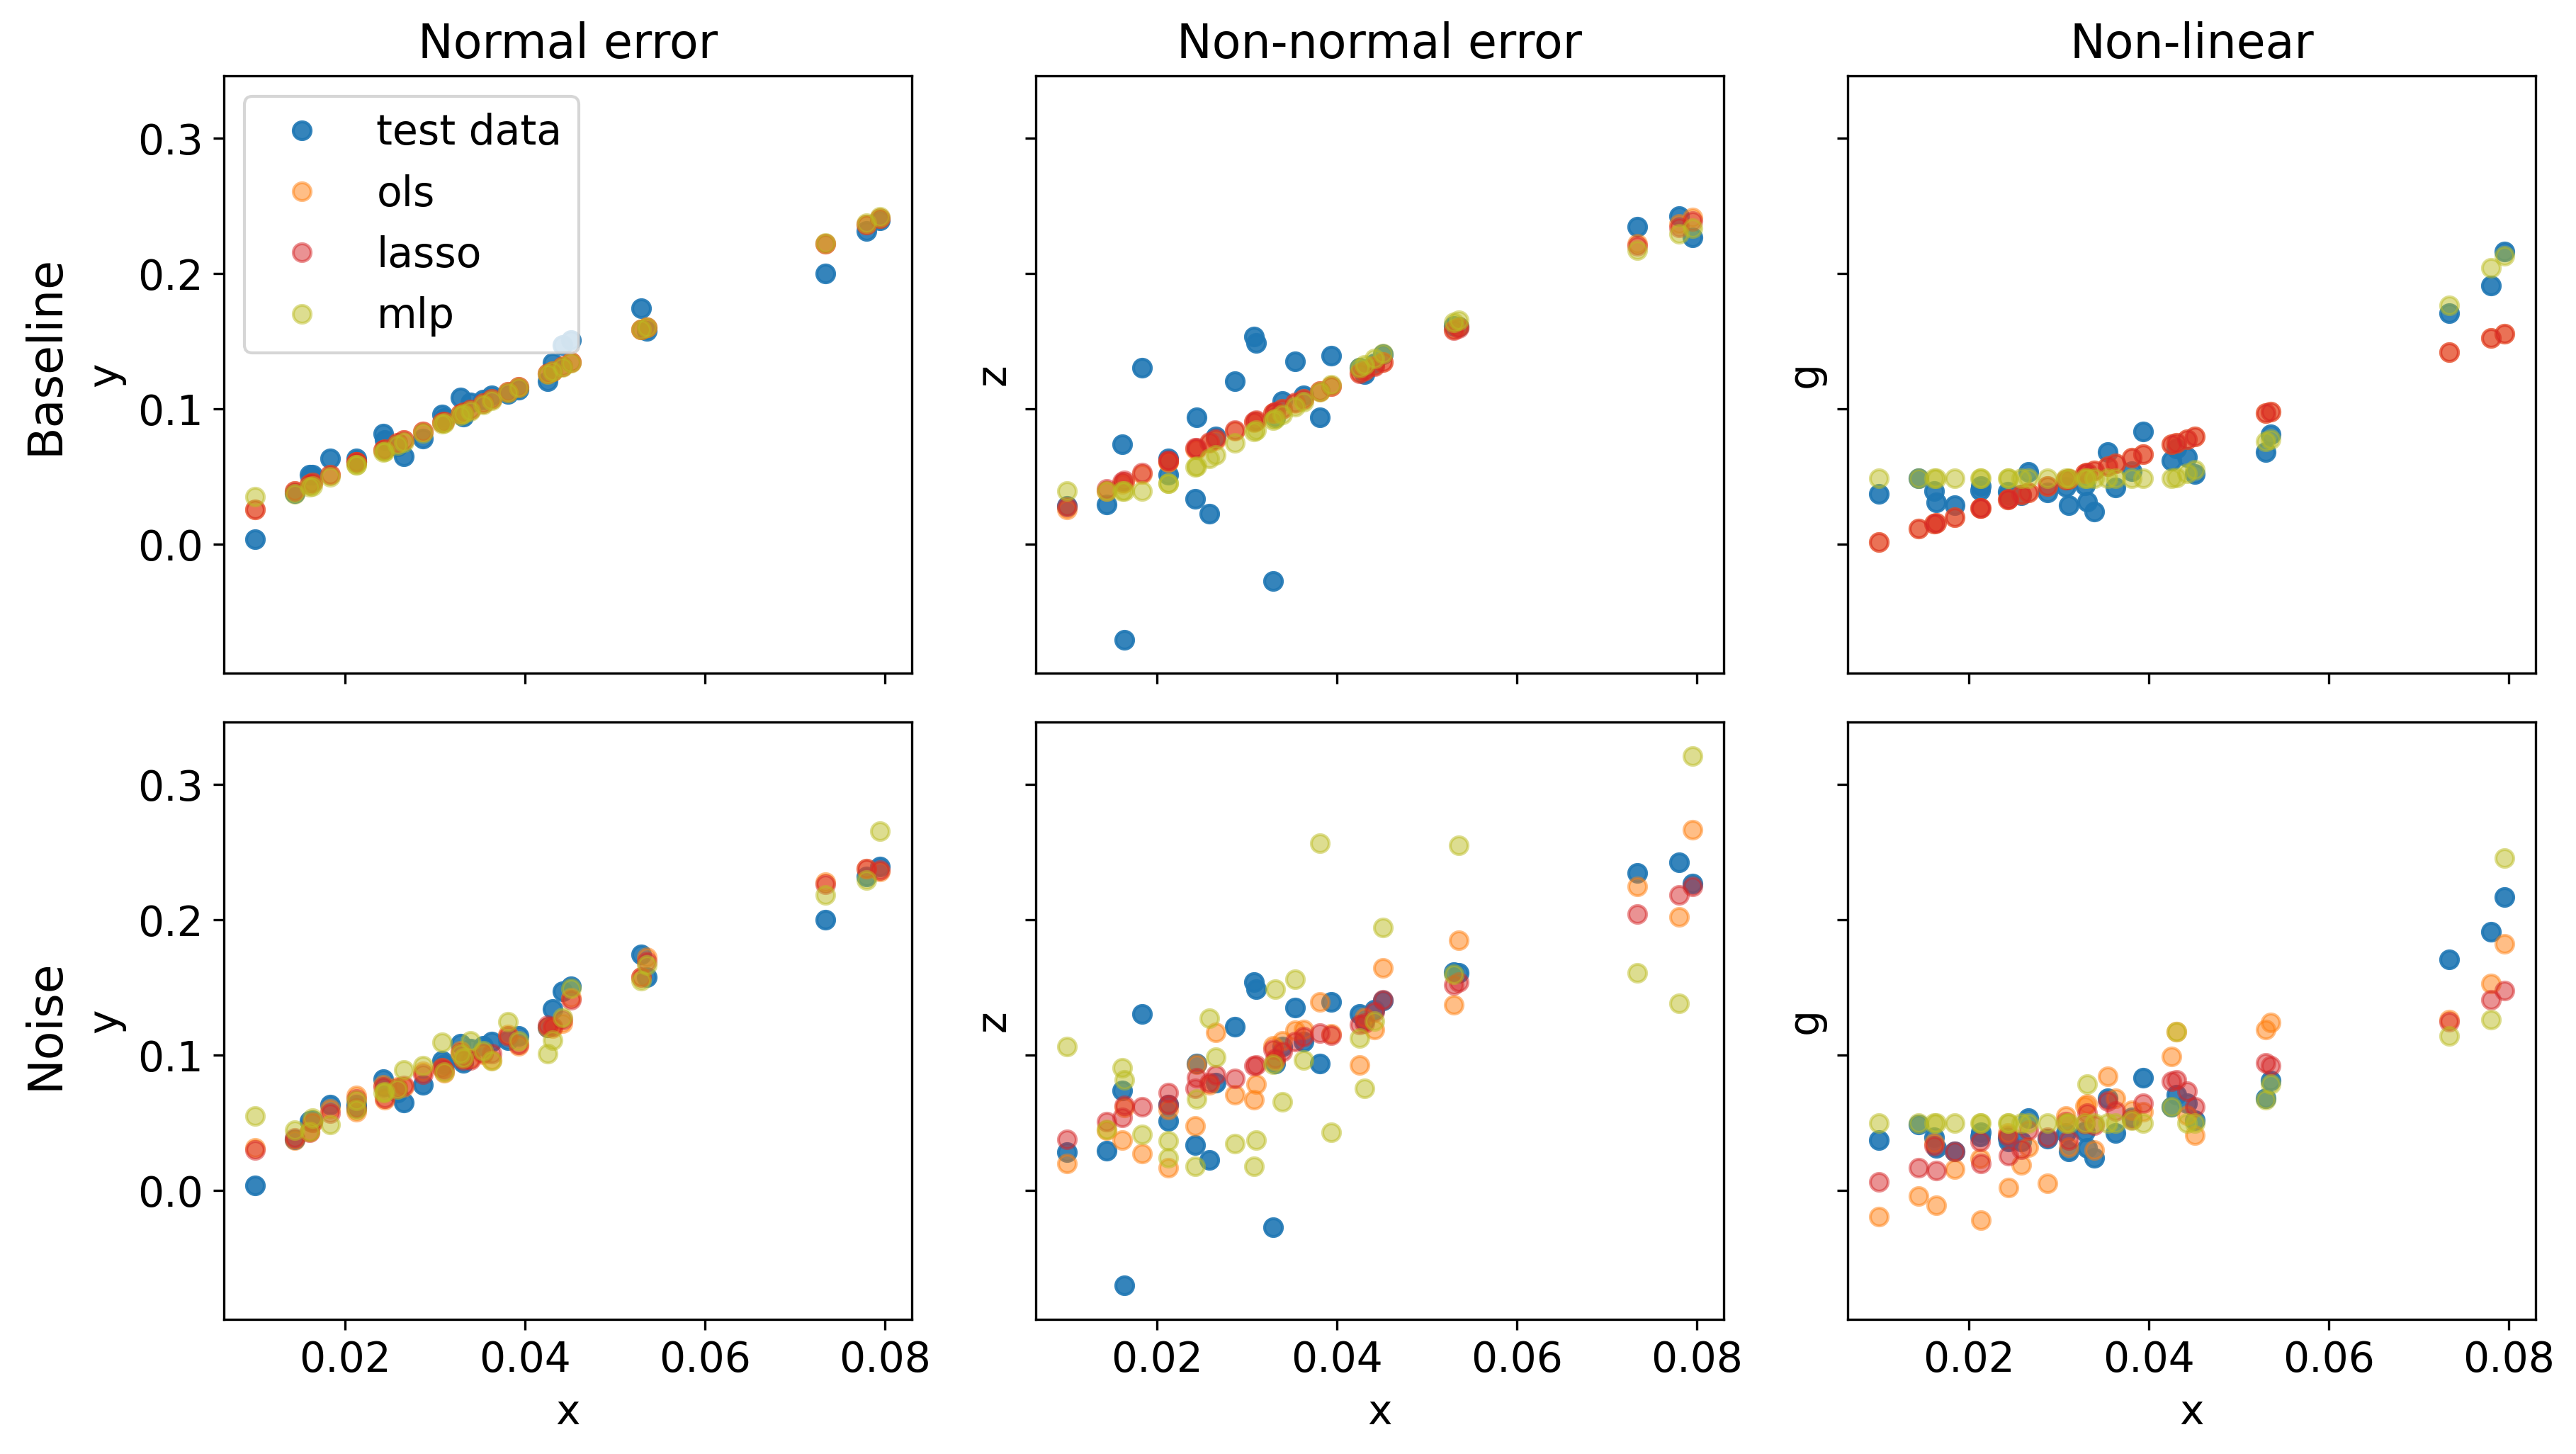

In [ ]:
datasets = [
    (x_test[:,1],
     [y1_test,      ols_pred1,      lasso_pred1,      mlp_pred1],
     'Normal error',    'y'),
    (x_test[:,1],
     [y2_test,      ols_pred2,      lasso_pred2,      mlp_pred2],
     'Non-normal error', 'z'),
    (x_test[:,1],
     [y3_test,      ols_pred3,      lasso_pred3,      mlp_pred3],
     'Non-linear',      'g'),
    (x_test_noise[:,1],
     [y1_test,      ols_pred1_n,    lasso_pred1_n,    mlp_pred1_n],
     None,              'y'),
    (x_test_noise[:,1],
     [y2_test,      ols_pred2_n,    lasso_pred2_n,    mlp_pred2_n],
     None,              'z'),
    (x_test_noise[:,1],
     [y3_test,      ols_pred3_n,    lasso_pred3_n,    mlp_pred3_n],
     None,              'g'),
]

# define the colours
colors = {
    'test data':   'C0',  
    'ols':         'C1',  
    'lasso':       'C3',  
    'mlp':         'C8',  
    # 'mlp w. L1': 'C6',  
}

labels = list(colors.keys())

# unified y‐limits
all_preds = [arr for _, pred_list, *_ in datasets for arr in pred_list]
ymin, ymax = np.min(all_preds) - 0.025, np.max(all_preds) + 0.025

# grid
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharex=True, sharey=True)

for idx, (ax, (xvals, preds, title, ylabel)) in enumerate(zip(axes.flat, datasets)):
    for yvals, lbl in zip(preds, labels):
        ax.plot(xvals, yvals, 'o',
                label=lbl,
                color=colors[lbl],
                alpha=(0.9 if lbl=='test data' else 0.5))
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=14)
    if title:
        ax.set_title(title, fontsize=16)
    if idx < 3:
        ax.tick_params(axis='x', which='both', labelbottom=False)
    else:
        ax.set_xlabel('x', fontsize=14)

# add dummy handle & draw legend only in the upper-left
ax0 = axes.flat[0]
ax0.legend(loc='upper left', fontsize=14)

fig.text(-0.01, 0.75, 'Baseline', va='center', rotation='vertical', fontsize=16)
fig.text(-0.01, 0.30, 'Noise', va='center', rotation='vertical', fontsize=16)


plt.tight_layout()
plt.savefig('output/simulation-scatter.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


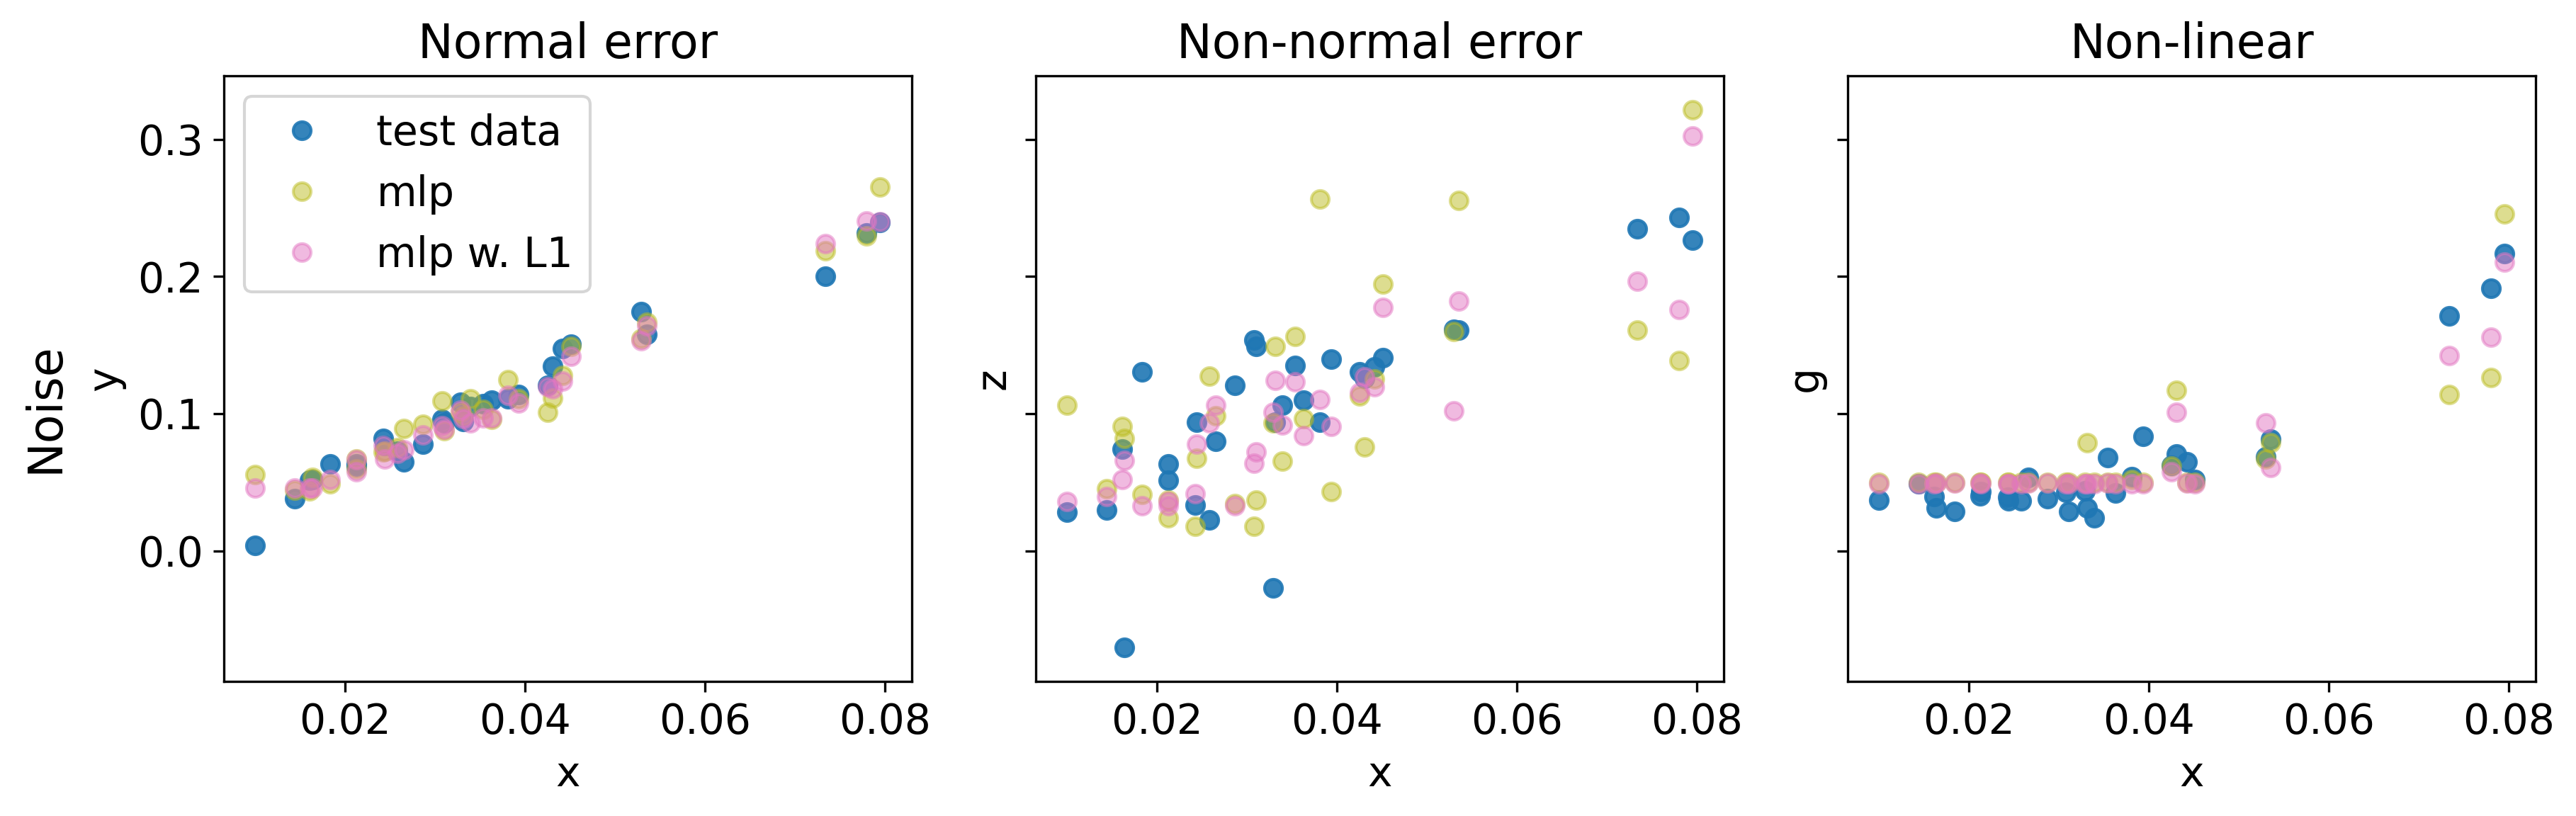

In [ ]:
datasets = [
    (x_test[:,1],
     [y1_test, mlp_pred1_n,    mlp_pred1_nR],
     'Normal error',    'y'),
    (x_test[:,1],
     [y2_test, mlp_pred2_n,    mlp_pred2_nR],
     'Non-normal error', 'z'),
    (x_test[:,1],
     [y3_test, mlp_pred3_n,    mlp_pred3_nR],
     'Non-linear',      'g'),
]

# define the colours
colors = {
    'test data':   'C0',     
    'mlp':         'C8',  
    'mlp w. L1': 'C6',  
}

labels = list(colors.keys())

# unified y‐limits
all_preds = [arr for _, pred_list, *_ in datasets for arr in pred_list]
ymin, ymax = np.min(all_preds) - 0.025, np.max(all_preds) + 0.025

# grid
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for idx, (ax, (xvals, preds, title, ylabel)) in enumerate(zip(axes.flat, datasets)):
    for yvals, lbl in zip(preds, labels):
        ax.plot(xvals, yvals, 'o',
                label=lbl,
                color=colors[lbl],
                alpha=(0.9 if lbl=='test data' else 0.5))
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=14)
    if title:
        ax.set_title(title, fontsize=16)
    ax.set_xlabel('x', fontsize=14)

ax0 = axes.flat[0]
ax0.legend(loc='upper left', fontsize=14)

fig.text(-0.01, 0.50, 'Noise', va='center', rotation='vertical', fontsize=16)


plt.tight_layout()
plt.savefig('output/simulation-scatter-mlp.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

In [32]:
n_train = np.arange(len(x_train))
n_test  = np.arange(len(x_train), len(x))
n_full  = np.arange(len(x))

plt.plot(n_full, y1, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred1, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred1, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred1, label='mlp', color='C8', alpha=0.7)

plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)

plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Data Generating Process")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/linear.png', dpi=300)
# plt.show()
plt.close()

In [33]:
n_train = np.arange(len(x_train))
n_test  = np.arange(len(x_train), len(x))
n_full  = np.arange(len(x))

plt.plot(n_full, y2, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred2, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred2, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred2, label='mlp', color='C8', alpha=0.7)
plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Data Generating Process w. non-normal error")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/linear-non-normal.png', dpi=300)
# plt.show()
plt.close()

In [34]:
plt.plot(n_full, y3, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred3, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred3, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred3, label='mlp', color='C8', alpha=0.7)
plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Non-linear Data Generating Process")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/non-linear-simul.png', dpi=300)
# plt.show()
plt.close()

In [35]:
# calculate the root mean squared error for each
rmse_ols1 = np.sqrt(np.mean((y1_test - ols_pred1)**2))
rmse_lasso1 = np.sqrt(np.mean((y1_test - lasso_pred1)**2))
rmse_mlp1 = np.sqrt(np.mean((y1_test - mlp_pred1)**2))

rmse_ols2 = np.sqrt(np.mean((y2_test - ols_pred2)**2))
rmse_lasso2 = np.sqrt(np.mean((y2_test - lasso_pred2)**2))
rmse_mlp2 = np.sqrt(np.mean((y2_test - mlp_pred2)**2))

rmse_ols3 = np.sqrt(np.mean((y3_test - ols_pred3)**2))
rmse_lasso3 = np.sqrt(np.mean((y3_test - lasso_pred3)**2))
rmse_mlp3 = np.sqrt(np.mean((y3_test - mlp_pred3)**2))

# calculate the root mean squared error for each with noise
rmse_ols1_n = np.sqrt(np.mean((y1_test - ols_pred1_n)**2))
rmse_lasso1_n = np.sqrt(np.mean((y1_test - lasso_pred1_n)**2))
rmse_mlp1_n = np.sqrt(np.mean((y1_test - mlp_pred1_n)**2))
rmse_mlp1_nR = np.sqrt(np.mean((y1_test - mlp_pred1_nR)**2))
rmse_ols2_n = np.sqrt(np.mean((y2_test - ols_pred2_n)**2))
rmse_lasso2_n = np.sqrt(np.mean((y2_test - lasso_pred2_n)**2))
rmse_mlp2_n = np.sqrt(np.mean((y2_test - mlp_pred2_n)**2))
rmse_mlp2_nR = np.sqrt(np.mean((y2_test - mlp_pred2_nR)**2))
rmse_ols3_n = np.sqrt(np.mean((y3_test - ols_pred3_n)**2))
rmse_lasso3_n = np.sqrt(np.mean((y3_test - lasso_pred3_n)**2))
rmse_mlp3_n = np.sqrt(np.mean((y3_test - mlp_pred3_n)**2))
rmse_mlp3_nR = np.sqrt(np.mean((y3_test - mlp_pred3_nR)**2))


# calculate mean absolute error
mae_ols1 = np.mean(np.abs(y1_test - ols_pred1))
mae_lasso1 = np.mean(np.abs(y1_test - lasso_pred1))
mae_mlp1 = np.mean(np.abs(y1_test - mlp_pred1))

mae_ols2 = np.mean(np.abs(y2_test - ols_pred2))
mae_lasso2 = np.mean(np.abs(y2_test - lasso_pred2))
mae_mlp2 = np.mean(np.abs(y2_test - mlp_pred2))

mae_ols3 = np.mean(np.abs(y3_test - ols_pred3))
mae_lasso3 = np.mean(np.abs(y3_test - lasso_pred3))
mae_mlp3 = np.mean(np.abs(y3_test - mlp_pred3))

# calculate mean absolute error for each with noise
mae_ols1_n = np.mean(np.abs(y1_test - ols_pred1_n))
mae_lasso1_n = np.mean(np.abs(y1_test - lasso_pred1_n))
mae_mlp1_n = np.mean(np.abs(y1_test - mlp_pred1_n))
mae_mlp1_nR = np.mean(np.abs(y1_test - mlp_pred1_nR))
mae_ols2_n = np.mean(np.abs(y2_test - ols_pred2_n))
mae_lasso2_n = np.mean(np.abs(y2_test - lasso_pred2_n))
mae_mlp2_n = np.mean(np.abs(y2_test - mlp_pred2_n))
mae_mlp2_nR = np.mean(np.abs(y2_test - mlp_pred2_nR))
mae_ols3_n = np.mean(np.abs(y3_test - ols_pred3_n))
mae_lasso3_n = np.mean(np.abs(y3_test - lasso_pred3_n))
mae_mlp3_n = np.mean(np.abs(y3_test - mlp_pred3_n))
mae_mlp3_nR = np.mean(np.abs(y3_test - mlp_pred3_nR))


models = ['OLS', 'LASSO', 'MLP', 'MLP w. L1']
metrics = {'*Baseline*RMSE*Normal error':[rmse_ols1, rmse_lasso1, rmse_mlp1,''],
           '*Baseline*RMSE*Non-normal error':[rmse_ols2, rmse_lasso2, rmse_mlp2,''],
           '*Baseline*RMSE*Non-linear':[rmse_ols3, rmse_lasso3, rmse_mlp3,''],
           '*Baseline*MAE*Normal error':[mae_ols1, mae_lasso1, mae_mlp1,''],
           '*Baseline*MAE*Non-normal error':[mae_ols2, mae_lasso2, mae_mlp2,''],
           '*Baseline*MAE*Non-linear':[mae_ols3, mae_lasso3, mae_mlp3,''],
           '*Noise*RMSE*Normal error':[rmse_ols1_n, rmse_lasso1_n, rmse_mlp1_n, rmse_mlp1_nR],
           '*Noise*RMSE*Non-normal error':[rmse_ols2_n, rmse_lasso2_n, rmse_mlp2_n, rmse_mlp2_nR],
           '*Noise*RMSE*Non-linear':[rmse_ols3_n, rmse_lasso3_n, rmse_mlp3_n, rmse_mlp3_nR],
           '*Noise*MAE*Normal error':[mae_ols1_n, mae_lasso1_n, mae_mlp1_n, mae_mlp1_nR],
           '*Noise*MAE*Non-normal error':[mae_ols2_n, mae_lasso2_n, mae_mlp2_n, mae_mlp2_nR],
           '*Noise*MAE*Non-linear':[mae_ols3_n, mae_lasso3_n, mae_mlp3_n, mae_mlp3_nR]}

tab = latex_table_nested(models,metrics)

print(tab)
with open('output/simulation_table.tex', 'w') as f:
    f.write(tab)


\begin{tabular}{cclcccc}
\hline\hline \\ [-1.8ex]
 &  &  & OLS & LASSO & MLP & MLP w. L1 \\ 
\hline 
\multirow[c]{6}{*}{\rotatebox{90}{Baseline}} & \multirow[c]{3}{*}{\rotatebox{90}{RMSE}} & Normal error & 0.00940 & 0.00940 & 0.01071 & - \\ 
  &  & Non-normal error & 0.04152 & 0.04158 & 0.04238 & - \\ 
  &  & Non-linear & 0.02250 & 0.02250 & 0.01371 & - \\ 
\cline{2-6}
  & \multirow[c]{3}{*}{\rotatebox{90}{MAE}} & Normal error & 0.00727 & 0.00727 & 0.00811 & - \\ 
  &  & Non-normal error & 0.02597 & 0.02599 & 0.02802 & - \\ 
  &  & Non-linear & 0.01830 & 0.01830 & 0.01149 & - \\ 
\cline{2-6}
\multirow[c]{6}{*}{\rotatebox{90}{Noise}} & \multirow[c]{3}{*}{\rotatebox{90}{RMSE}} & Normal error & 0.01133 & 0.01056 & 0.01573 & 0.01275 \\ 
  &  & Non-normal error & 0.05132 & 0.04401 & 0.07869 & 0.05657 \\ 
  &  & Non-linear & 0.03237 & 0.02306 & 0.02415 & 0.01733 \\ 
\cline{2-6}
  & \multirow[c]{3}{*}{\rotatebox{90}{MAE}} & Normal error & 0.00879 & 0.00819 & 0.01186 & 0.00945 \\ 
  &  & Non-n